# Complete Project Flow

### Welcome to this project by Nihal Jahagirdar to develop a Deep Learning Controller for ISRO Project. This demo will explain and show working of handling a an external uncontrollable change in the J value.



Firstly, we setup stuff, the environment etc.
This next cell imports everything we need.


In [37]:
!pip install tensorflow==2.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 796.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling 

In [2]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [3]:
import math
import matplotlib.pyplot as plt
import time
import pandas as pd
import csv
from keras.models import Sequential, load_model
from keras.layers import Dense
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import random
import json

This cell modularizes the entire simulation.

Usage:

> `sim(Kp = float, Kd = float, J = float, showGraph = boolean)`

**Input parameters:**

*Kp:* Give the Kp value without converting

*Kd:* Give the Kd value without converting

*J:* Give the J value for Plant working




*showGraph:* True by default. Set to False to skip showing graph and return params instead.


**Returns (output):** -> List

[sT, unsettled, overshoot, overshootTime , crossCount, riseTime, KpDeg, KdDeg, J]

*float sT:* Time taken to arrive within 2% of input signal (in degrees)

*int unsettled:* 1 if output signal does not settle within the entire time duration

*float overshoot:* maximum output signal before graph settles, in degrees

*float overshootTime:* time at which overshoot occurs

*int crossCount:* Number of times the output graph crosses the input signal throughout the entire time duration

*float riseTime:* Time taken by the output to reach to 90% of the input signal

*float Kp, Kd, J:* As given in input

Example:
```
params = sim(Kp = 0.11, Kd = 0.34, J=22000)
```
```
params = sim(Kp = a, Kd = b, J=j, showGraph = False)
```
```
params = sim(Kp = 0.11, Kd = 0.34, J=22000, showGraph = False)
```

In [4]:
def sim(Kp = 0.103, Kd = 0.40, J = 22000, showGraph = True):
    PI = math.pi #PI exact
    # L = 100 #Total time = 100seconds
    dT = 0.1   #Time Interval = 0.1second
    totalTime = 100 #in seconds
    stepInputStartTime = 1 # in seconds.
    stepInputSignalDegrees = 50 # in degrees, the input step.
    errorPercent = 2

    L = int(totalTime/dT)
    #thetaRef = [0]*L
    thetaRef = [stepInputSignalDegrees * PI/180]*L
    thetaFeedback = [0]*L
    error = [0]*L
    Tc = [0]*L
    R = [0]*L
    P = [0]*L
    Vo = [0]*L
    PlantIn = [0]*L
    PlantOut = [0]*L
    intgt1 = [0]*L
    intgt2 = [0]*L

    def diff(a, k):
        return(a[k] - a[k-1])/dT
    KpDeg = Kp
    KdDeg = Kd
    Kp = Kp * 180/PI
    Kd = Kd* 180/PI

    error[0]= 0 # 50 * PI/180
    Km = 12.25
    Tm = 0.128
    Uon = 1.0
    Uoff = -0.15
    Um = 1.0
    #J = 10k-30k
    PlantK = 300/J

    stepInputStart = int(stepInputStartTime /dT)
    # for i in range(stepInputStart,L):
    #     thetaRef[i] = stepInputSignalDegrees * PI/180
    for i in range(stepInputStart):
        thetaRef[i] = 0

    degreeOut = [0]*L
    thetaDeg = [0]*L
    crossCount = 0
    sTimeSample = 0
    sBand = errorPercent * 0.01 * stepInputSignalDegrees
    sBandNegative = stepInputSignalDegrees - sBand
    sBandPositive = stepInputSignalDegrees + sBand
    overshoot = 0
    overshootTime = 0
    unsettled = 0
    riseTime = 0
    firstRise = True
    for k in range (1, L):
        error[k] = thetaRef[k] - thetaFeedback[k-1]
        Tc[k] = Kp * error[k] + Kd * diff(error, k)
        R[k] = Tc[k] - Vo[k]
        #Transfer Fn 1
        P[k] = (Tm/(dT+Tm))*P[k-1] + (Km*dT/(dT+Tm))*R[k]
        #Hysterisis
        if P[k] > Uon:
            Vo[k] = Um
        elif P[k] < -1*Uon:
            Vo[k] = -1*Um
        elif -Uoff < P[k] < Uoff:
            Vo[k] = 0
        elif P[k] < Uon and P[k] > Uoff:
            if Vo[k] == Um:
                Vo[k] = Um
            else:
                Vo[k] = 0
        else:
            if Vo[k] == -Um:
                Vo[k] = -Um
            else:
                Vo[k] = 0
        #End Hysterisis
        #Actuator
        PlantIn[k] = (0.04/(dT+0.04))*PlantIn[k-1] + (1*dT/(dT+0.04))*Vo[k]
        #Plant
        PlantOut[k] = PlantIn[k]*PlantK
        intgt1[k] = intgt1[k-1] + dT*PlantOut[k]
        intgt2[k] = intgt2[k-1] + dT*intgt1[k]
        thetaFeedback[k] = intgt2[k]
        #End Plant

        degreeOut[k] = intgt2[k]*180/PI
        thetaDeg[k] = thetaRef[k]*180/PI
        #Cross count
        if (degreeOut[k]>=stepInputSignalDegrees>degreeOut[k-1]) or (degreeOut[k-1]>stepInputSignalDegrees>=degreeOut[k]):
            crossCount+=1
        #Rise Time
        if degreeOut[k]>= 0.9*stepInputSignalDegrees and firstRise:
            riseTime = k*dT
            firstRise = False
        #Settling band
        if sBandNegative< degreeOut[k] < sBandPositive:
            continue
        if L-(5/dT)<k<L:
            unsettled = 1
        sTimeSample = k+1
    #Done Main Loop
    #Overshoot and Time
    for k in range(1, sTimeSample):
        if degreeOut[k] > overshoot:
            overshoot = degreeOut[k]
            overshootTime = k*dT

    sT = (sTimeSample) * dT - stepInputStartTime
    overshoot = overshoot-stepInputSignalDegrees

    #Plot graph
    if showGraph:
        plt.plot([i for i in range(1,L)], degreeOut[1:])
        plt.plot([i for i in range(1,L)], thetaDeg[1:])
        plt.xlabel("Time (sampling)")
        plt.ylabel("Output")
        plt.legend(['degreeOut', 'InputDeg', 'd'], loc='upper right')
        plt.text(L*0.60,0,f"J = {J}\nKp = {Kp*PI/180}*180/PI\nKd = {Kd*PI/180}*180/PI\nOvershoot = {overshoot}\nSettling time = {sT}s\nCross Count = {crossCount}\nUnsettled = {unsettled}\nRise Time = {riseTime}\nOvershoot Time = {overshootTime}")
        plt.show()
    return [sT, unsettled, overshoot, overshootTime , crossCount, riseTime, KpDeg, KdDeg, J]

##The Deep Learning model


**IMPORTANT**:
Ensure JPredictor.keras is present in same directory before running.

This cell modularizes the entire simulation.

Syntax:

> `float predictJ(List)`

**Input parameters:**

*list params:* List of length 9 of the same format returned by previously discussed ***sim*** function


**Returns (output):** -> float

*float J:* The J value predicted by the Deep learning AI model.

Example:
```
predictedJ = predictJ(params)
```


In [5]:
def predictJ(X):
  originalJ = X[8]
  X = X[:8]
  JPredictor_model = load_model("JPredictor.keras")
  predictedJ = JPredictor_model.predict([X])
  return predictedJ[0][0]

##Lookup Function

This function maps J to the ideal Kp, Kd values.

**IMPORTANT**:
Ensure ***lookup.json*** is present in same directory before running.

Syntax:

> `List lookup(float)`

**Input parameters:**

*float J:* The J value, ideally predicted by the Deep Learning model.


**Returns (output):** -> list

*list [Kp, Kd]:* A list of length 2 which contains the Kp and Kd value as shown

Example:
```
[Kp, kd] = lookup(predictedJ)
```


In [6]:
with open("lookup.json", 'r') as f:
    lookupDict = json.load(f)
def lookup(J):
    if J>30000:
      J = 30000
      print("WARNING: J out of range (lower)")
    if J<10200:
      J = 10200
      print("WARNING: J out of range (higher)")

    J = float(J - J%200 + (0 if J%200<110 else 200))
    return random.choice(lookupDict[str(J)])

Now we are done defining and intializing everything. Lets try out our scenario now.


---

#SCENARIO
We have assigned an optimal Kp and Kd value already for a given J and it generates a satisfactory output signal based on simulation ran on these values for the expected ideal J, of say 22000

In [16]:
Kp = 0.173
Kd = 0.51
J=11400

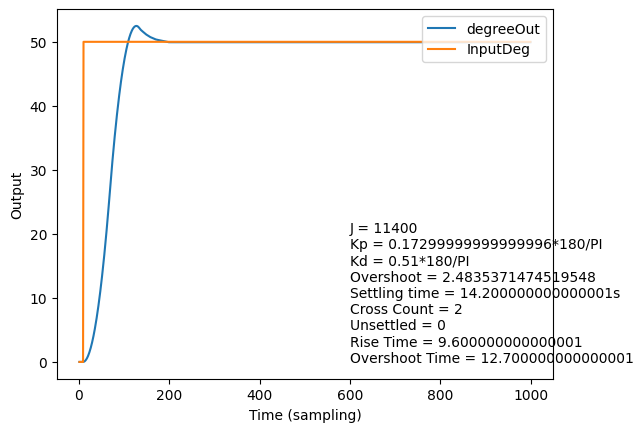

In [18]:
params = sim(Kp=Kp, Kd=Kd, J=J, showGraph=True)

The above simulation tells us we had a settling time of 14.2 seconds which is satisfactory.

Now due to some external factor, consider that J has changed, without our control, to 26476

In [19]:
J = 26476

Now when we run and check the simulation for our same Kp, Kd, the following is the result.

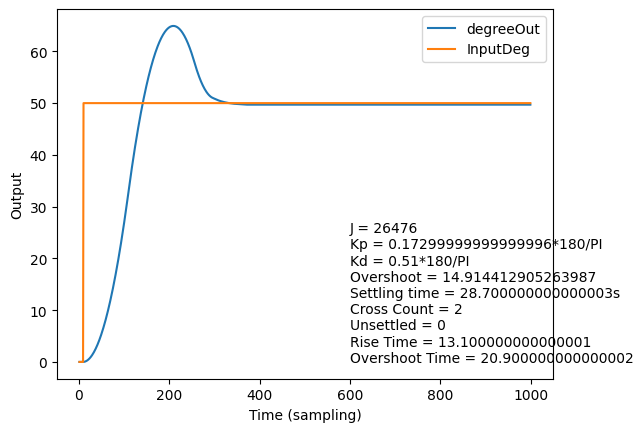

In [21]:
params = sim(Kp=Kp, Kd=Kd, J=J, showGraph=True)

We can see the settling time is now 28.7 seconds, which is bad and not acceptable to us.

Hence we now use our Deep Learning model to predict this expected change in J and hence lookup the new Kp, Kd values

In [22]:
predicted_J = predictJ(params)
[Kp, Kd] = lookup(predicted_J)
print("Predicted new J value: "+ str(predicted_J))
print("Error in J value: "+ str(abs(predicted_J-params[-1]))[:10])
print("New Kp Kd values: "+str([Kp, Kd]))

1/1 [==============================] - 0s 127ms/step
Predicted new J value: 25924.188
Error in J value: 551.8125
New Kp Kd values: [0.10980000000000001, 0.49999999999999994]


Now that we have updated the Kp, Kd values for the new J, We can run the simulation again and see how it performs.

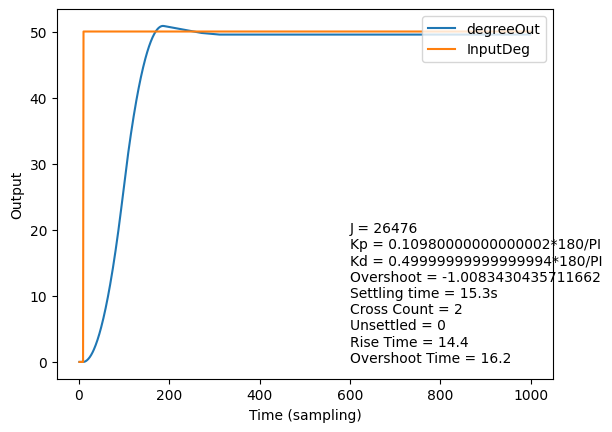

In [23]:
params = sim(Kp=Kp, Kd=Kd, J=J, showGraph=True)

The settling time has reduced now which is again well within our satisfactory limits.

This hence shows how we were able to predict the change in J and accordingly fix the Kp, Kd values.

---

We can also run the Deep Learning model again on the params generated in this simulation, incase the first iteration result was not satisfactory enough. This will be a second iteration which can happen automatically if the ettling time is not within our satisfaction anyways.